# Theta Model Forecaster

The theta model is a forecasting method presented by V. Assimakopoulos and K. Nikolopoulos. The basic idea behind this method is the decomposition of the original time series into **short and long term components**. Other popular methods decompose time series into a seasonal, a trend and an error component. However, the Theta Model produces new time series, denoted "theta lines" by modifying the **second order difference** of the original time series by multiplying it by a real value, called theta. Then, we produce forecasts for each of the underlying time series components (**extrapolation**) and finally we **combine** all forecasts to obtain the final forecast for the original time series.

In this tutorial, we will first dive into the intuition behind the "theta lines". Secondly, we will implement step by step the algorithm. Then, we compare our implementation results with other popular time series libraries. Finally, we implement the alternative appropach presented in the paper "Unmasking the Theta method" by Rob J Hyndman and Baki Billah, where they prove that the Theta Model with two theta lines at 0 and 2 is equivalent to simple exponential smoothing with drift forecasts.

## 0. Preliminaries

In this tutorial we will use two datasets: shampoo sales and the airline dataset. The first one describes the monthly number of sales of shampoo over a 3 year period. The units are a sales count. The second one describes the monthly totals of international airline passengers, 1949 to 1960.

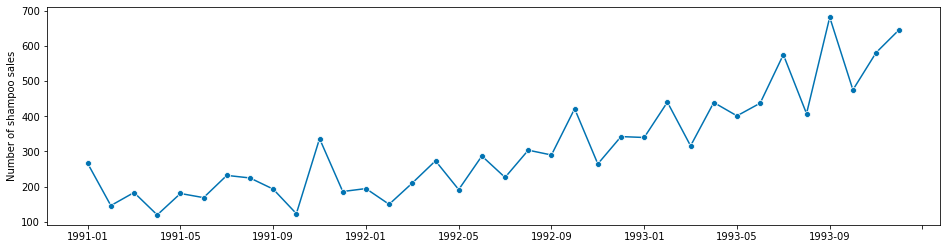

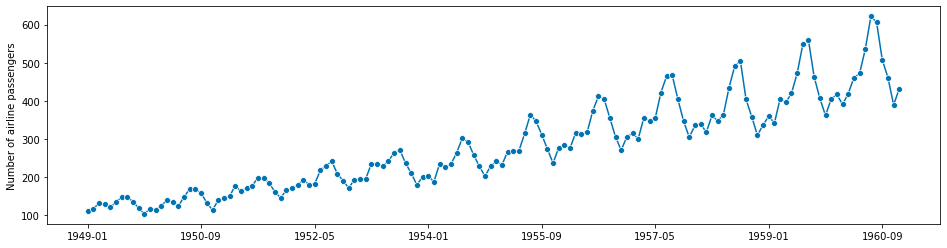

In [1]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.forecasting.theta import ThetaModel
from functions import mae
from sktime.forecasting.theta import ThetaForecaster
from statsmodels.tsa.api import SimpleExpSmoothing
from sktime.forecasting.arima import AutoARIMA

X = load_shampoo_sales()
fig, ax =  plot_series(X)
y = load_airline()
fig, ax =  plot_series(y)

## 1. Understanding theta lines

The Theta Model is based on the idea of decomposing the deseasonalized time series into what V. Assimakopoulos and K. Nikolopoulos call "Theta lines". The reason behind this approach is to combine both long term components (such as gradual increase/decrease) and short term variations. To do so, they produce "theta lines", i.e, time series equivalent to the initial one but with modified curvature. They define a constant, theta, that regulates the amount of modification of the curvatures. A theta value of 0 produces a fitted linear regression line. The higher the value of theta, the more curvature the corresponding theta line has.

Before digging into how to compute these "theta lines", take a look at the plot below to visualize different theta lines for the shampoo sales dataset.

In [2]:
x = X.values

In [3]:
def get_x_data(x):
    return x[2:]-2*x[1:-1]+x[:-2]

In [4]:
def get_theta_line(x, theta):
    n = len(x)
    b = (6/(n*n -1))*((2/n)*np.dot(x, np.arange(1, len(x)+1)) 
                     - ((1+n)/n)*np.sum(x))
    a = (1/n)*np.sum(x)-((n+1)/2)*b
    z_t = theta*x +(1-theta)*(a+b*np.arange(1,n+1))
    return z_t

In [5]:
theta_values = [0, 0.5, 1,  2]
z_lines = []
legend = ["original time series"]
for z in theta_values:
    legend.append("theta line with theta = {}".format(z))
    z_lines.append(pd.Series(get_theta_line(x,z ), index = X.index))

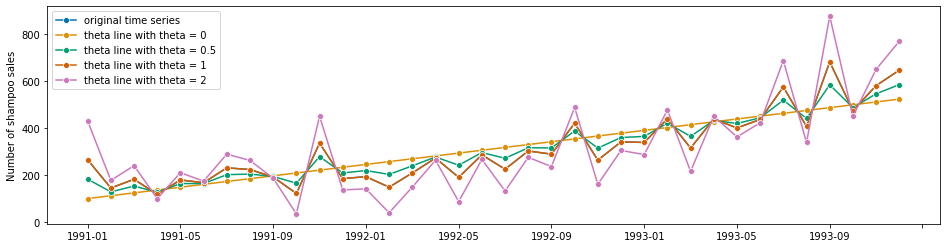

In [6]:
x_data = get_x_data(x)
theta = 1

fig, ax =  plot_series(X, z_lines[0], z_lines[1], z_lines[2], z_lines[3], labels=legend)

We observe how the curvature of the series increases with theta. Also, check that theta=1 reconstructs the original time series.

To compute these "theta lines", the theta coefficient is applied to the second order difference of the time series. Mathematically, 
$$ \nabla^2 Y_{t, \theta} = \theta \nabla^2 X_{t} $$

This equation states that the second order difference of the theta line at $\theta$, $Y_{t, \theta}$, is equivalent to the second order difference of the original time series $X_{t}$ multiplied by the coefficient $\theta$.

There is an analytical solution for the above equation:
$$ Y_{t, \theta} = \theta X_{t} + (1-\theta)(a+bt)$$ 
where
$$a = \frac{1}{n}\sum_{t=1}{n} X_{t} - \frac{1+n}{2}b$$
$$b = \frac{6}{n^2 -1}\left(\frac{2}{n}\sum_{t=1}^{n}tX_{t}-\frac{1+n}{n}\sum_{t=1}^{n}X_{t}\right)$$

For more details, check the paper of Grzegorz Dudek, "Short-term load forecasting using Theta method".

## 2. Theta Model pipeline

To produce forecasts using the Theta Model, A&N propose the following pipeline
* Deseasonalization: remove the seasonal pattern from the series.
* Decomposition: decompose the deseasonalized time series into theta lines. In the M3 competition and the original paper, they decompose the series into two theta lines with $\theta_1 = 0$ and $\theta_2 = 2$.
* Extrapolation: produce forecasts for each of the theta lines. In the original paper they use linear regression to forecast the theta line at $\theta_1 = 0$ and Simple Exponential Smoothing for the theta line at $\theta_2 = 2$. However, any forecasting technique can be used in this step for each of the theta lines.
* Combination: theta line forecasts are equally weighted and added up to produce the deseasonalized forecast.
* Reseasonalization: the combined forecast is reseasonalized with the initially found season.

To reproduce this pipeline, we separate the data into training and test set.

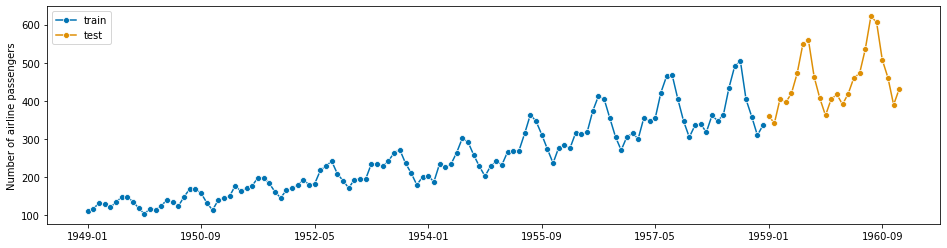

In [7]:
y_train, y_test = y[:-24], y[-24:]
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

### 2.1 Deseasonalization

In order to remove the seasonal patter present in our data, we visually inspect the time series and the ACF-PCF plots.

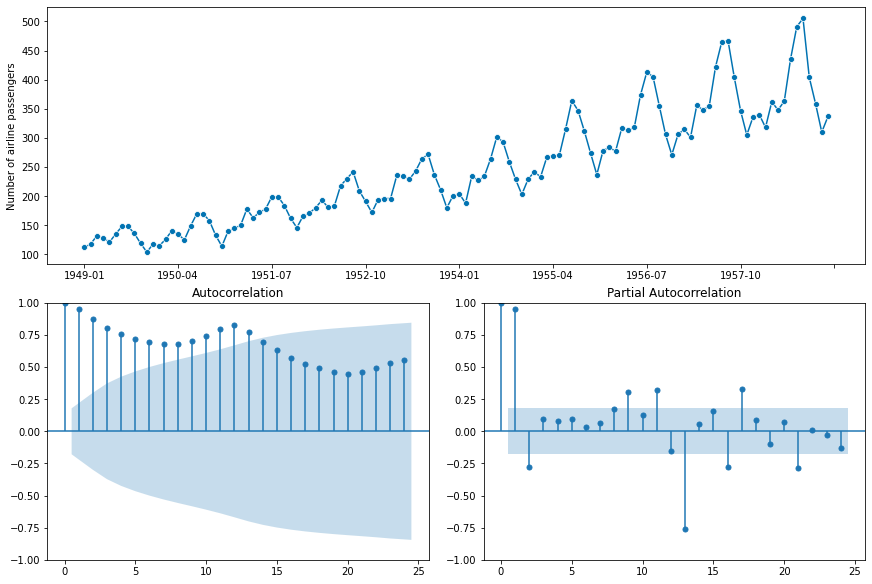

In [8]:
fig, ax = plot_correlations(y_train)

From the ACF plot we see that there is a seasonal pattern, and that there is a maximum at lag 12 indicating yearly seasonality. We also observe that it is a multiplicative model, as the pattern get's wider with time. Let's remove it. 

In [9]:
decompose_result = seasonal_decompose(y_train.values, period = 12, model="multiplicative")

seasonal = decompose_result.seasonal


We can visualize the seasonal component of our time series.

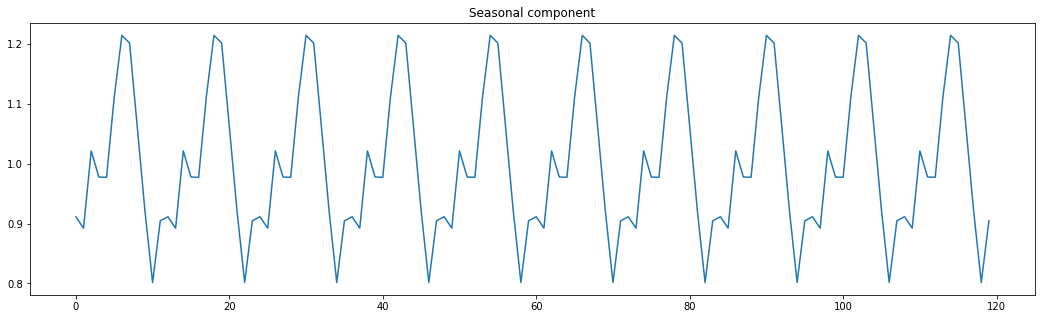

In [10]:
plt.figure(figsize=(18,5))
plt.title("Seasonal component")
plt.plot(seasonal)
plt.show()

As we know that it is a multiplicative seasonal pattern, to remove it we just need to divide the values of our time series by the found seasonal pattern.

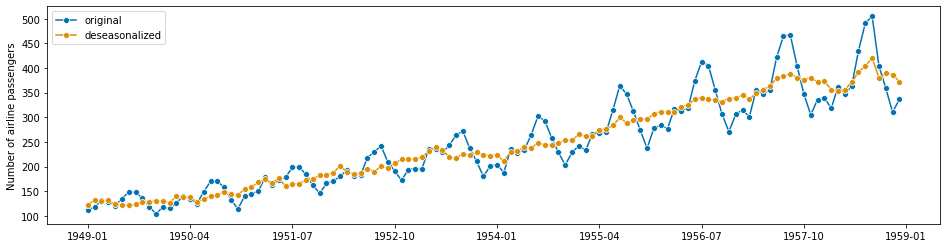

In [11]:
y_deseason = y_train/seasonal
fig, ax = plot_series(y_train, pd.Series(y_deseason, index=y.index), labels=["original", "deseasonalized"])

```statsmodels```'s ```seasonal_decompose``` method also returns the trend and error components. In the following plot we just show that we can regenerate the original time series by multiplying each of the components, confirming that we are in front of a purely multiplicative time series.

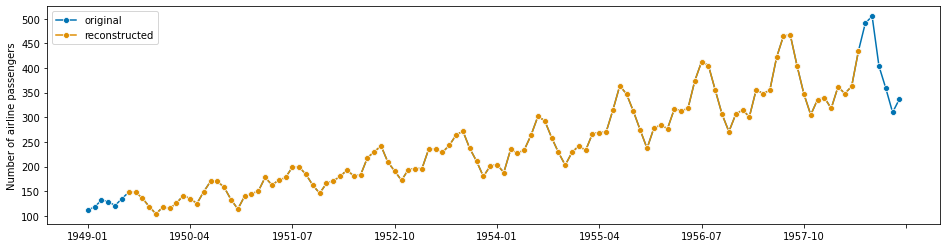

In [12]:
trend = decompose_result.trend
residual = decompose_result.resid
y_reconstructed = trend*seasonal*residual
fig, ax = plot_series(y_train,pd.Series(y_reconstructed, index=y_train.index), labels=["original", "reconstructed"])

### 2.2 Decomposition

The next step is to generate the theta lines for the selected theta coefficients based on the deseasonalized time series.

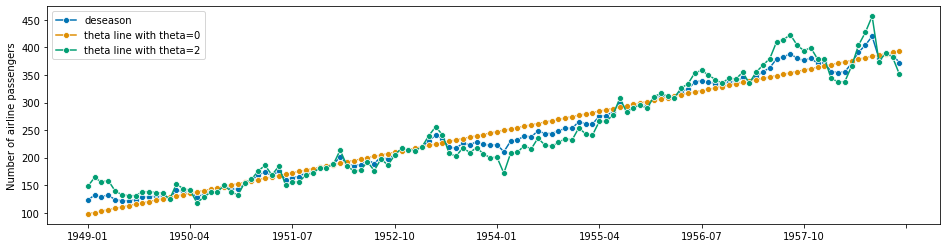

In [13]:
thetaline1 = get_theta_line(y_deseason, 0)
thetaline2 = get_theta_line(y_deseason, 2)
fig, ax = plot_series(pd.Series(y_deseason, index=y_train.index), thetaline1, thetaline2, labels=["deseason", "theta line with theta=0", "theta line with theta=2"])

### 2.3. Extrapolation

Then, we forecast the first theta line with linear regression and the second one using SES.

In [14]:
window = 24
fh_date = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1959-01", periods=window, freq="M")), is_relative=False
)
fh_date

ForecastingHorizon(['1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)

In [15]:
fh_num = np.arange(len(y_train), len(y_train)+window, 1)
fh_num

array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143])

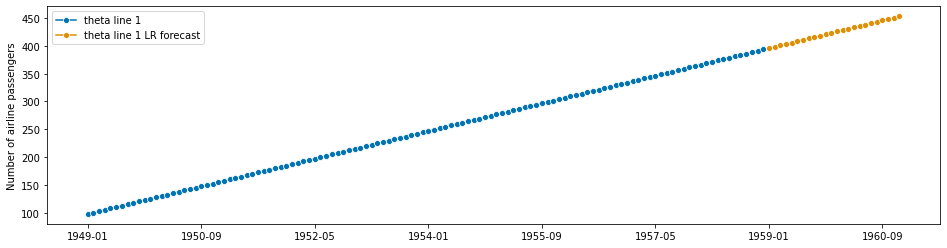

In [16]:
model = LinearRegression()
model = model.fit(np.arange(0, len(y_train), 1).reshape(-1, 1), thetaline1.values)
thetaline1_forecast = pd.Series(model.predict(fh_num.reshape(-1,1)), index = fh_date)
fig, ax = plot_series(thetaline1, thetaline1_forecast, labels=["theta line 1", "theta line 1 LR forecast"])

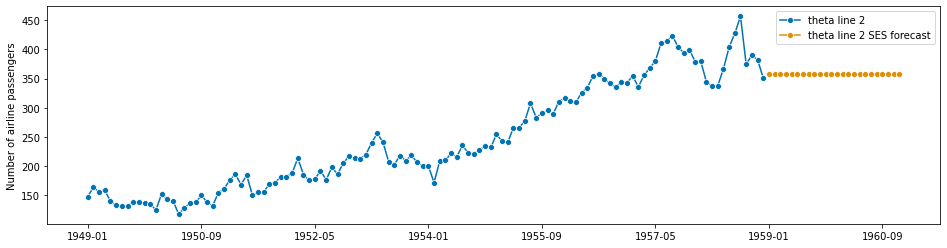

In [17]:
model = SimpleExpSmoothing(thetaline2)
alpha = 0.8
model = model.fit(smoothing_level=alpha)
thetaline2_forecast = model.forecast(window)
fig, ax = plot_series(thetaline2, thetaline2_forecast, labels=["theta line 2", "theta line 2 SES forecast"])

Keep in mind that SES forecasts produce a unique value, that's why we get a flat prediction.

### 2.4. Combination

We combine both theta line forecasts to produce a deseasonalized forecast. Each forecast has the same weight.

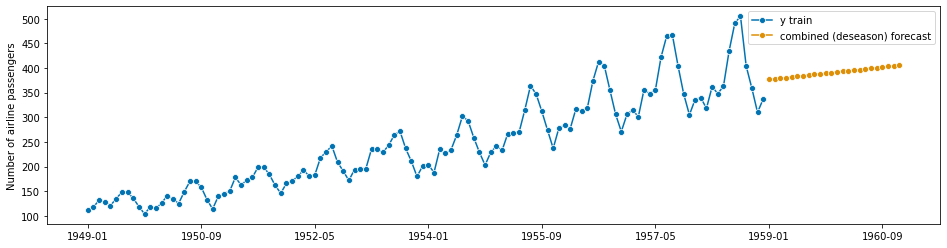

In [18]:
forecast_combined = 0.5*(thetaline1_forecast + thetaline2_forecast)
fig, ax = plot_series(y_train, forecast_combined, labels=["y train", "combined (deseason) forecast"])

### 2.5. Reseasonalization

... and multiply by the detected season.

MAE: 61.00913096526104


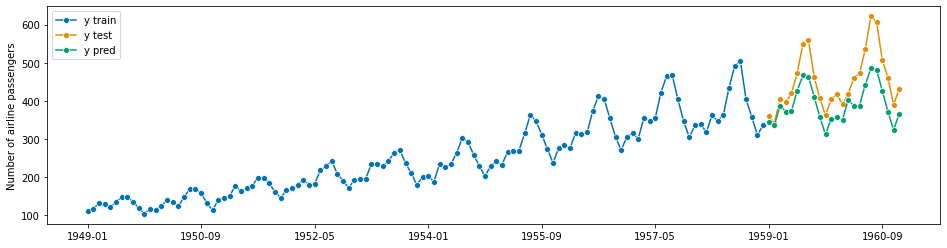

In [19]:
season = seasonal[-window:]
forecast_1 = forecast_combined*season
fig, ax = plot_series(y_train, y_test, forecast_1, labels=["y train", "y test", "y pred"])
print("MAE: {}".format(mae(y_test, forecast_1)))


### 2.6 BONUS EXPERIMENT: Improving extrapolation for theta line 2

The extrapolation step for theta line time series can be done with any forecaster. In this experiment, I just produced forecasts for the second theta line using Auto ARIMA model. The result is a more accurate final prediction than the previous approach that used SES forecasting. Indeed, the error is almost reduced to half.

/home/claudia/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/claudia/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/claudia/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


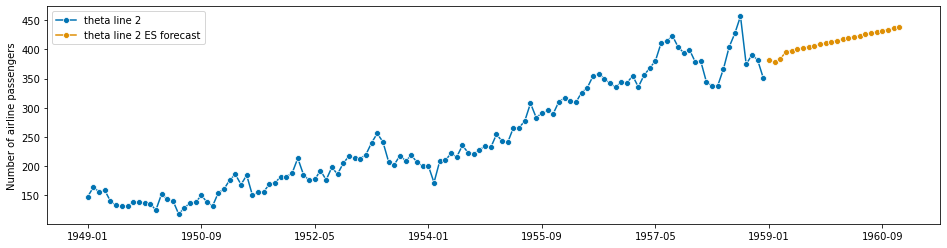

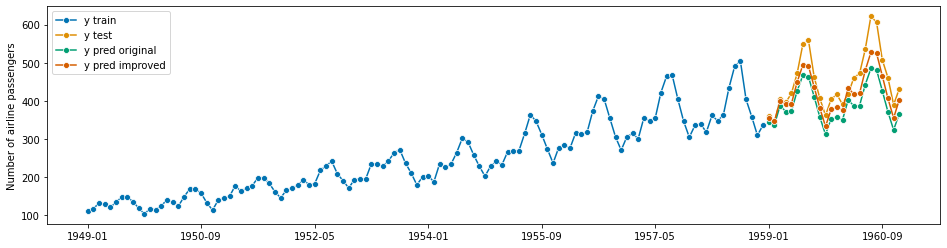

In [20]:
model = AutoARIMA(seasonal=False)
model = model.fit(thetaline2)
thetaline2_forecast_2 = model.predict(fh_date)
fig, ax = plot_series(thetaline2, thetaline2_forecast_2, labels=["theta line 2", "theta line 2 ES forecast"])

forecast_deseason = 0.5*(thetaline1_forecast + thetaline2_forecast_2)

season = seasonal[-window:]
forecast_2 = forecast_deseason*season
fig, ax = plot_series(y_train, y_test, forecast_1, forecast_2, labels=["y train", "y test", "y pred original","y pred improved"])

In [21]:
print("MAE Original Claudia model: {}".format(mae(y_test, forecast_1)))
print("MAE Improved Claudia model: {}".format(mae(y_test, forecast_2)))

MAE Original Claudia model: 61.00913096526104
MAE Improved Claudia model: 35.32712886410643


### 2.7 BONUS EXPERIMENT 2: optimized combination weights of theta lines

I just wanted to try what happened if we weighted differently the theta lines. Theoretically, when combining theta lines we assign to each prediction the same weight. However, I tried to increase the weight of the first theta line (the long term component) and I got a higher accuracy than the original implementation.

MAE Original Claudia model: 61.00913096526104
MAE Improved Claudia model: 42.04600504034465


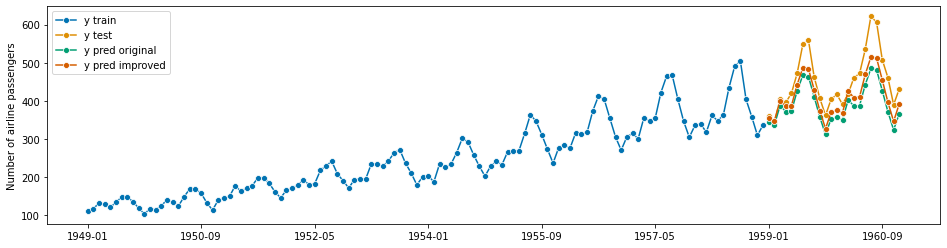

In [22]:
forecast_deseason = 0.8*thetaline1_forecast + 0.2*thetaline2_forecast

season = seasonal[-window:]
forecast_3 = forecast_deseason*season
fig, ax = plot_series(y_train, y_test, forecast_1, forecast_3, labels=["y train", "y test", "y pred original","y pred improved"])

print("MAE Original Claudia model: {}".format(mae(y_test, forecast_1)))
print("MAE Improved Claudia model: {}".format(mae(y_test, forecast_3)))

Taking this into account, could we find what are the optimal weights for combining theta lines? Let's look for the best combination in our test set.

In [23]:
def tune_weights(y, thetaline1, thetaline2):
    min_error = np.inf
    argmin_w = -1
    for w in np.arange(0.0,1.01,0.01):
        y_hat = w*thetaline1+(1-w)*thetaline2
        error = mae(y, y_hat)
        if error<min_error:
            min_error = error
            argmin_w = w
    return argmin_w

In [24]:
w = tune_weights(y_test, thetaline1_forecast, thetaline2_forecast)
print("We should weight the first theta line by {} and the second by {}".format(w, 1-w))

We should weight the first theta line by 1.0 and the second by 0.0


It looks like we are getting the best prediction by only taking into account the first theta line, disregarding the forecast for the second theta line. So, in this case, a linear regression line with the multiplicative season added is the best forecasting option using the Theta Methodology. This makes complete sense, because we know from previous sections that this time series is a multiplicative model obtained by the product of the season, the trend (LR fit) and error (unpredictable). Adding the second theta line forecast adds complexity and noise to our simple LR model.

MAE Original Claudia model: 61.00913096526104
MAE Improved Claudia model: 30.94229949773116


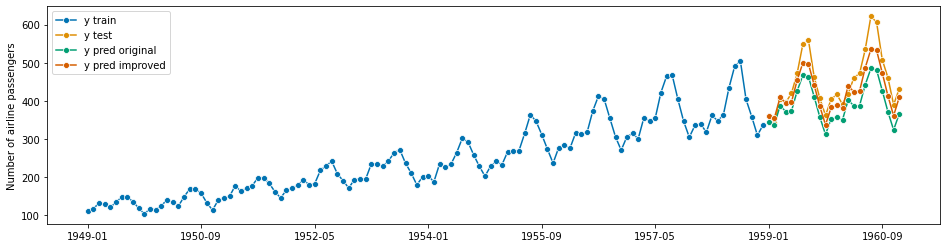

In [25]:
forecast_deseason = w*thetaline1_forecast + (1-w)*thetaline2_forecast

season = seasonal[-window:]
forecast_3 = forecast_deseason*season
fig, ax = plot_series(y_train, y_test, forecast_1, forecast_3, labels=["y train", "y test", "y pred original","y pred improved"])

print("MAE Original Claudia model: {}".format(mae(y_test, forecast_1)))
print("MAE Improved Claudia model: {}".format(mae(y_test, forecast_3)))

Quick note: this combination weight is a hyperparameter that should be selected in a validation set, no directly on the test set. If we tune the hyperparameter with the training data, we get that both theta lines should be weighted equally. As we see in the plot below, this weightening reconstructs perfectly the original deseasonalized time series.

In [26]:
w = tune_weights(y_deseason, thetaline1, thetaline2)
print("We should weight the first theta line by {} and the second by {}".format(w, 1-w))

We should weight the first theta line by 0.5 and the second by 0.5


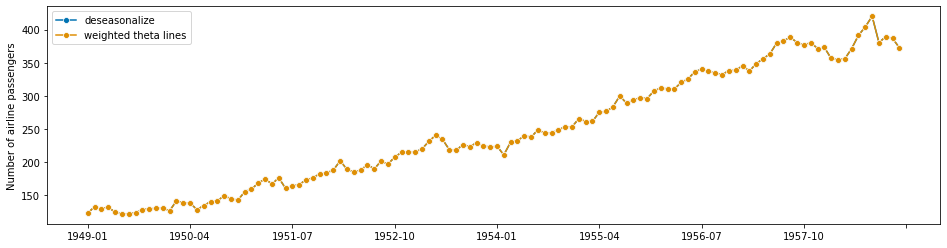

In [27]:
y_hat =  0.5*(thetaline1+thetaline2)
fig, ax = plot_series(y_deseason, y_hat, labels = ["deseasonalize", "weighted theta lines"])

### 2.8 Final model

Finally, I include a class for this model, with the SES implementation also done from scratch.

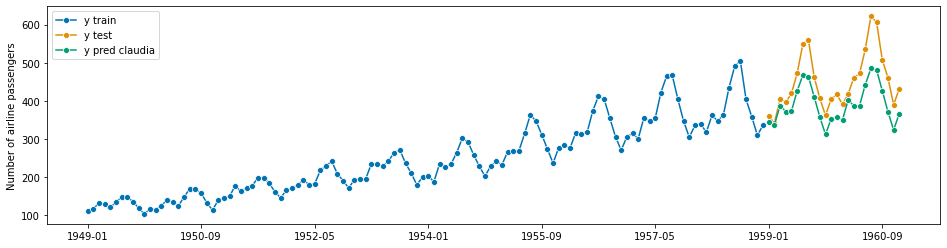

In [28]:
from functions import SES

class ThetaModelClaudia:
    @staticmethod
    def get_theta_line(x, theta):
        n = len(x)
        b = (6/(n*n -1))*((2/n)*np.dot(x, np.arange(1, len(x)+1)) 
                         - ((1+n)/n)*np.sum(x))
        a = (1/n)*np.sum(x)-((n+1)/2)*b
        z_t = theta*x +(1-theta)*(a+b*np.arange(1,n+1))
        return z_t

    def fit(self, y, period, alpha=None, l0=None):
        #deseasonalization
        decompose_result = seasonal_decompose(y, period = period, model="multiplicative")
        self.seasonal = decompose_result.seasonal
        y_deseason = y/self.seasonal
        
        #decomposition
        self.thetaline1 = self.get_theta_line(y_deseason, 0)
        self.thetaline2 = self.get_theta_line(y_deseason, 2)
        
        self.n = len(y)
        self.alpha = alpha
        self.l0=l0
        return self
    
    def predict(self, fh):
        #extrapolation
        model = LinearRegression()
        model = model.fit(np.arange(0, self.n, 1).reshape(-1, 1), self.thetaline1.values)
        thetaline1_forecast = model.predict(np.arange(self.n, self.n+fh).reshape(-1,1))
        
        model = SES()
        model = model.fit(self.thetaline2, self.alpha, self.l0)#, optimize =False, alpha=self.alpha, l0=self.l0)
        thetaline2_forecast = model.predict(fh)
        
        #combination 
        forecast_combined = 0.5*(thetaline1_forecast + thetaline2_forecast)

        #reseasonalization
        season = self.seasonal[-fh:].values
        return forecast_combined*season

model = ThetaModelClaudia()
model = model.fit(y_train, 12, alpha=0.8)
forecast_4 = model.predict(window)
fig, ax = plot_series(y_train, y_test, pd.Series(forecast_4, index=y_test.index), labels=["y train", "y test", "y pred claudia"])


## 3. Critisizim: Unmasking the theta model

The original paper "The theta model: a decomposition approach to forecasting" has been critisized by reducing this approach simply by a SES model with drift. The main paper explaining this reasoning is "Unmasking the Theta Model". It is true that the mathematics and the notation in the original paper is cumbersome, and could be explained much more simply, as demonstrated by Hyndman et al. Furthermore, they claim that the theta model is a SES with drift. 
Mathematically, forecasts produced with the Theta Model result in:
$$\hat{X_n}(h)=\tilde{X_n}(h) + \frac{1}{2}\hat{b_0}(h-1+1/\alpha)$$ where $\tilde{X_n}(h)$ is the SES forecast of our deseasonalized time series, $h$ is the forecasting horizon, $\alpha$ is the smoothing parameter and $\hat{b_0}$ is obtained as explained previously in the Theta method.

In the following code we show that this reasoning holds when we are using only two theta lines with $\theta_1 = 0$ and $\theta_2 = 2$-

In [29]:
def theta_unmasked(x, alpha, h):
    n = len(x)
    b_hat_0 = (6/(n*n -1))*((2/n)*np.dot(x, np.arange(1, len(x)+1)) 
                     - ((1+n)/n)*np.sum(x))
    model = SimpleExpSmoothing(x)
    model = model.fit(alpha)
    x_forecast_ses = model.forecast(h)
    return x_forecast_ses + 0.5*b_hat_0*(np.arange(1,h+1)-1+1/alpha)

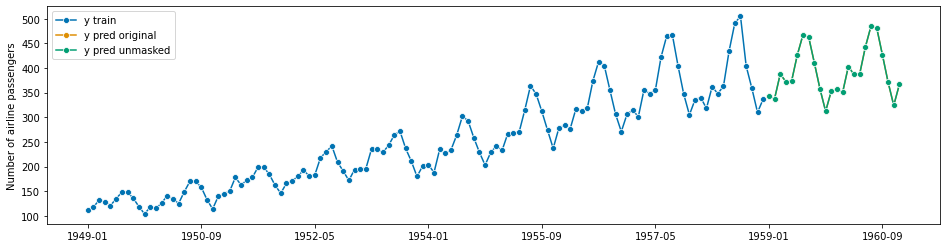

In [30]:
forecast_unmasked = theta_unmasked(y_deseason, alpha, window)
forecast_5 = forecast_unmasked*season
fig, ax = plot_series(y_train, forecast_1, forecast_5, labels=["y train", "y pred original", "y pred unmasked"])


In [31]:
print("MAE Original Claudia model: {}".format(mae(y_test, forecast_1)))
print("MAE Unmasked Claudia model: {}".format(mae(y_test, forecast_5)))
print("The MAE between the original and the unmasked implementation is {:.2f}".format(mae(forecast_1, forecast_5)))

MAE Original Claudia model: 61.00913096526104
MAE Unmasked Claudia model: 61.00913096526103
The MAE between the original and the unmasked implementation is 0.00


We see that the pipeline approach and the SES+drift approach produce numerically the same forecast. 

However, Hyndman et al only show their simplification of the Theta Model for the particular case of applying two theta lines of $\theta_1 = 0$ and $\theta_2 = 2$ forecasted with LR and SES. For sure, if we increase the number of theta lines and use different forecasting techniques (always following the Theta Model pipeline) we obtain different results than a SES model + drift.

For future work, I leave the optimized SES+drift model, where the trend slope, $b$ is optimized via maximum likelihood estimation, instead of fixing it to $b_0/2$, as it is done in the Theta Model.

I leave below the scratch version (using my SES implementation) of this unmasked approach:

In [32]:
class ThetaModelClaudia_Unmasked:
    def fit(self, y, period, alpha=None, l0=None):
        decompose_result = seasonal_decompose(y, period = period, model="multiplicative")
        self.seasonal = decompose_result.seasonal
        y_deseason = y/self.seasonal
        n = len(y_deseason)
        self.b_hat_0 = (6/(n*n -1))*((2/n)*np.dot(y_deseason, np.arange(1, n+1)) 
                         - ((1+n)/n)*np.sum(y_deseason))
        ses_model = SES()
        self.ses_model = ses_model.fit(y_deseason, alpha, l0) #fit SES model in deseasonalized signal, optimize parameters
        self.alpha = self.ses_model.alpha
        return self
        
    def predict(self, fh):
        x_forecast_ses = self.ses_model.predict(fh)
        season = self.seasonal[-fh:].values
        self.drift = 0.5*self.b_hat_0*(np.arange(1,fh+1)-1+1/self.alpha)
        return (x_forecast_ses + self.drift)*season

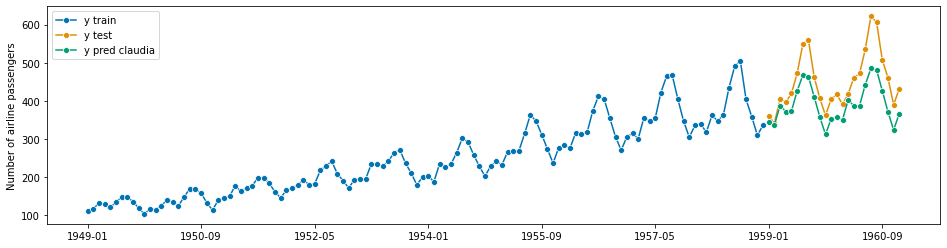

In [33]:
model = ThetaModelClaudia_Unmasked()
model = model.fit(y_train, 12, alpha=0.8)
forecast_6 = model.predict(window)
fig, ax = plot_series(y_train, y_test, pd.Series(forecast_6, index=y_test.index), labels=["y train", "y test", "y pred claudia"])

In [34]:
print("MAE Original Claudia model: {}".format(mae(y_test, forecast_4)))
print("MAE Unmasked Claudia model: {}".format(mae(y_test, forecast_6)))
print("The MAE between the original and the unmasked implementation is {:.2f}".format(mae(forecast_4, forecast_6)))

MAE Original Claudia model: 61.00913096526104
MAE Unmasked Claudia model: 61.009130965261136
The MAE between the original and the unmasked implementation is 0.00


## 4. Comparison to library implementations

In this section, we show that our implementation and the implementations by ```statsmodels``` and ```sktime``` are nearly the same.

MAE Original Claudia model: 61.00913096526104
MAE Statsmodels model: 63.221630822604986
MAE Sktime model: 61.97150577043681


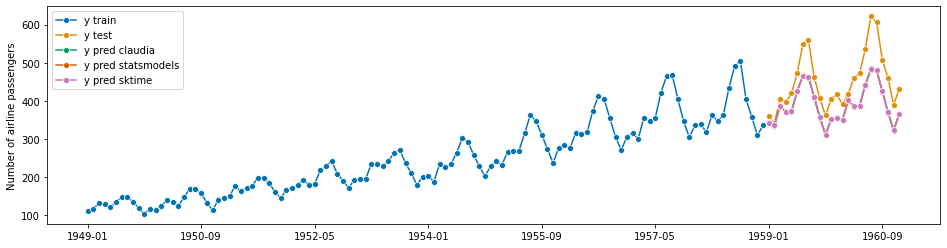

In [35]:
model = ThetaModel(y_train, period = 12)
model = model.fit()
forecast_7 = model.forecast(window)

model = ThetaForecaster(sp=12)
model = model.fit(y_train)
forecast_8 = model.predict(fh_date)

fig, ax = plot_series(y_train, y_test, forecast_1, forecast_7, forecast_8, labels=["y train", "y test", "y pred claudia", "y pred statsmodels", "y pred sktime"])
print("MAE Original Claudia model: {}".format(mae(y_test, forecast_4)))
print("MAE Statsmodels model: {}".format(mae(y_test, forecast_7)))
print("MAE Sktime model: {}".format(mae(y_test, forecast_8)))

The main difference between my model and sktime is the computation of the drift, as I use the original drift proposed by Hyndman et al.

## References

* V. Assimakopoulos, K. Nikolopoulos, The theta model: a decomposition approach to forecasting, International Journal of Forecasting, Volume 16, Issue 4, 2000, Pages 521-530, ISSN 0169-2070, https://doi.org/10.1016/S0169-2070(00)00066-2.
* Rob J. Hyndman, Baki Billah, Unmasking the Theta method, International Journal of Forecasting, Volume 19, Issue 2, 2003, Pages 287-290, ISSN 0169-2070, https://doi.org/10.1016/S0169-2070(01)00143-1.
* Dudek, Grzegorz. (2019). Short-term load forecasting using Theta method. E3S Web of Conferences. 84. 01004. 10.1051/e3sconf/20198401004. 